<a href="https://colab.research.google.com/github/arvishcdoshi/LoRA-FT/blob/main/LoRA_Sample_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

Generate synthetic House Pricing Data

In [2]:
# Generate synthetic data for house prices
np.random.seed(42)
num_samples = 500

# Features: house size (sq ft) and location index
X = np.random.rand(num_samples, 2) * 100

# True price equation: Price = 50 * Size + 30 * Location + Noise
y = 50 * X[:, 0] + 30 * X[:, 1] + np.random.randn(num_samples) * 10
y = y.reshape(-1, 1)

# Split into training and test sets
train_size = int(0.8 * num_samples)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

print(f"Training Samples: {X_train.shape}, Test Samples: {X_test.shape}")


Training Samples: (400, 2), Test Samples: (100, 2)


Define LoRA Layer

How This Works:

W is frozen (not updated during training).

A and B are trained, capturing task-specific knowledge.

The LoRA update A⋅B adapts the model with fewer parameters.

In [3]:
class LoRALayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim, rank=2, alpha=1.0):
        super(LoRALayer, self).__init__()
        self.rank = rank
        self.alpha = alpha  # Scaling factor

        # Main frozen weight matrix
        self.W = self.add_weight(shape=(input_dim, output_dim), initializer="random_normal", trainable=False)

        # LoRA trainable low-rank matrices
        self.A = self.add_weight(shape=(input_dim, rank), initializer="random_normal", trainable=True)
        self.B = self.add_weight(shape=(rank, output_dim), initializer="random_normal", trainable=True)

    def call(self, inputs):
        lora_update = tf.matmul(inputs, self.A) # XA
        lora_update = tf.matmul(lora_update, self.B) * self.alpha # XAB alpha
        return tf.matmul(inputs, self.W) + lora_update  # W is frozen, only A and B update
        # X W + XAB alpha
        # X (W + AB aplha)


Build Regression Model with LoRA

In [4]:
# Define the model with LoRA
input_dim = X_train.shape[1]
output_dim = 1  # Predicting house price

inputs = keras.Input(shape=(input_dim,))
x = LoRALayer(input_dim, 16, rank=2, alpha=1.0)(inputs)  # LoRA applied here
x = layers.ReLU()(x)
x = layers.Dense(1)(x)  # Final regression output
model = keras.Model(inputs, x)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mse")

Train the Model

In [5]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18171558.0000 - val_loss: 15934557.0000
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17140840.0000 - val_loss: 13471788.0000
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13563754.0000 - val_loss: 5566766.5000
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3877731.5000 - val_loss: 144022.4531
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 202933.4375 - val_loss: 106477.0000
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 95663.9375 - val_loss: 73875.0391
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 71376.3125 - val_loss: 47780.0547
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 41699.7773 - val_loss: 31127.8828
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30313.9648 - val_loss: 18940.1934
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18404.5645 - val_loss: 11242.2334
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms

Performance Evaluation

Test Loss (MSE): 95.24671173095703


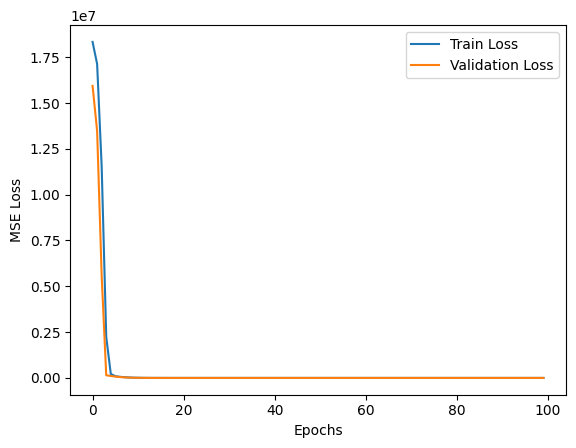

In [6]:
# Evaluate on test data
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss}")

# Plot training loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()